# Caso de estudio - Predicción del precio de la vivienda en Boston
Daniel Alejandro Alonso Bastos

En el presente trabajo se utiliza la metodología general vista a lo largo del curso para predecir el precio de una vivienda en Boston, se utiliza una base de datos bastante popular que se puede descargar en https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html.

Para ejecutar de manera correcta el notebook es necesario tener los siguientes archivos en el mismo directorio del notebook:
- El archivo ejecutable __ppmz2.exe__ para realizar la compresión de los archivos y calcular el número de términos para el problema.
- El archivo __FastAscentAlgorithmFunctions.py__ para obtener las funciones necesarias para ejecutar el FAA.
- El archivo __EGAFunctions.py__ para obtener las funciones necesarias para ejecutar el EGA.
- EL conjunto de datos se encuentran en __data/housing_boston.csv__

## Librerías

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import time
import shutil
import math
import plotly.graph_objects as go
import sys
import seaborn as sn
from pandas.plotting import scatter_matrix

import FastAscentAlgorithmFunctions as FAA # programa que contiene las funciones para ejecutar FAA
import EGAFunctions as EGA # librebria que contiene las funciones para ejecutar el EGA

from IPython.display import display, Latex, Image

import warnings

#suppress warnings
warnings.filterwarnings('ignore')

## Funciones

La función _scaleData_ escala los datos tal que transforma los valores confinados en un rango $[a,b]$ a un rango típicamente $[-1,1]$ o $[0,1]$. Para realizar el escalamiento de $[a,b)\rightarrow [0,1)$ se utiliza la siguiente ecuación:
    \begin{equation}
        V_{i}^{*}=\frac{V_i-a}{b-a}
    \end{equation}

In [13]:
def scaleData(df):
    '''
    Funcion para escalar los datos de un rango [a,b) -> [0,1)
    
    Inputs:
    df - dataframe con los datos a escalar
    
    Return:
    df_scale - dataframe escalado
    '''
    df_scale = df.copy() # realizar una copia del df original
    for col in df.columns: # iterar sobre cada columna del df
        a = df[col].min() # calcular el minimo de la columna col
        b = df[col].max() # calcular el maximo de la columna col
        df_scale[col] = (df[col]-a)/(b-a) # escalar la columna col y guardar en df_scale
    
    return df_scale

## Descripción de los datos

In [30]:
# lectura de la base de datos
df_housing = pd.read_csv('data/housing_boston.csv')
df_housing

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [3]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


La base de datos cuenta con 14 atributos y 506 tuplas de casas en diversos barrios en Boston. A continuación se describen cada uno de los atributos:
1. CRIM. Índice de criminalidad per capita
2. ZN. Proporción de superficie residencial establecida en lotes mayores a 25,000 sq.t ($\approx 2.3m^2$)
3. INDUS. Proporción de negocio no minorista.
4. CHAS. Variable _dummy_ para determinar si el tramo considerado está en la ribera del río Charles (1) o no (0).
5. NOX. Concentración de óxidos de nitrógeno (partes por 10 millones)
6. RM. Número promedio de habitaciones por vivienda.
7. AGE. Proporción de viviendas en propiedad ocupadas, construidas antes de 1940.
8. DIS. Distancias ponderadas a cinco centros de empleo en Boston.
9. RAD. Índice de accesibilidad a las autopistas radiales.
10. TAX. Parte del impuesto de bienes inmuebles por cada $\$10,000$ de propiedad.
11. PTRATIO. Ratio de alumnos por profesor.
12. B. Se calcula como $1000(Bk-0.63)^2$, donde $Bk$ es la proporción de personas de descendencia afroamericana.
13. LSTAT. Porcentaje de población de "estatus de bajo nivel"
14. __PRICE. Mediana del valor de viviendas en propiedad en miles de dólares. Este atributo es la variable dependiente.__

Se observa que los valores de todas las variables son valores numéricos y que no existen valores nulos en la base de datos.

## Selección de variables

A continuación se realiza un análisis exploratio para determinar las variables necesarias para obtener el modelo.

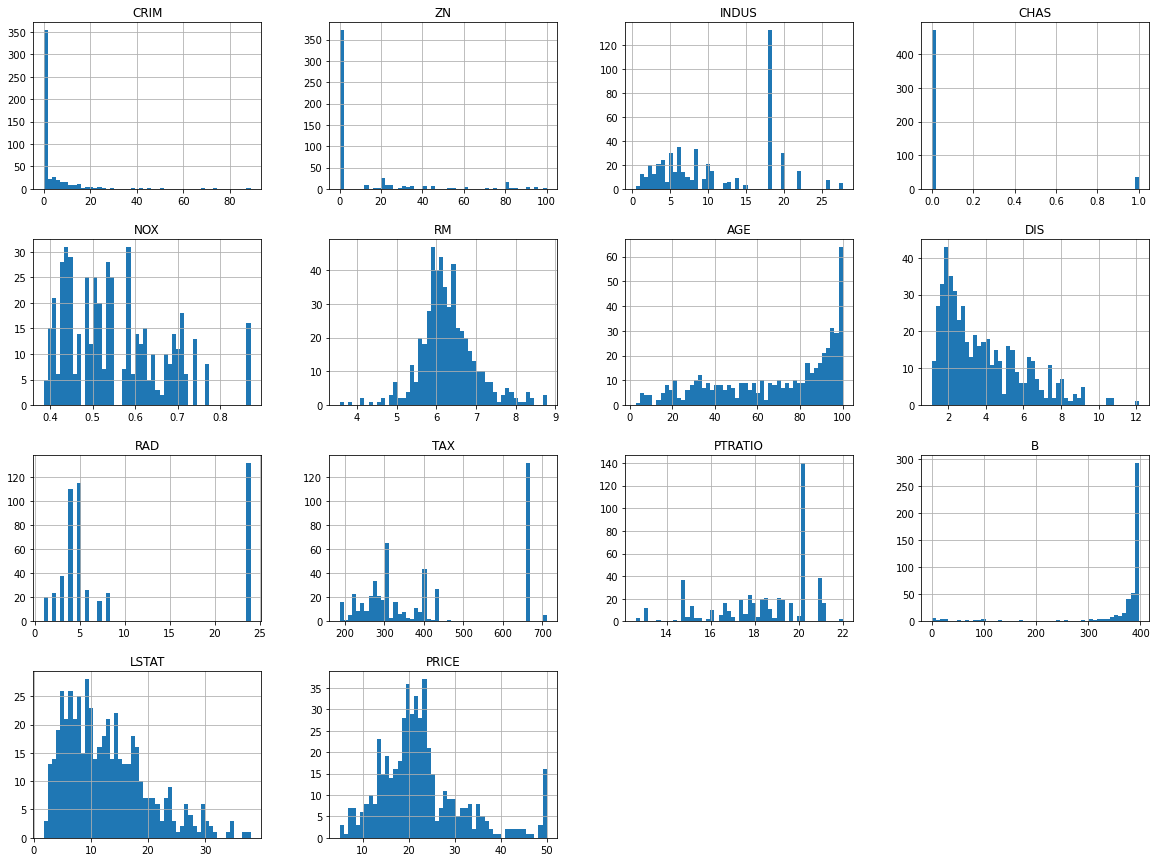

In [4]:
# histogram plot for each numerical attribute
%matplotlib inline
df_housing.hist(bins=50, figsize=(20,15))
plt.show()

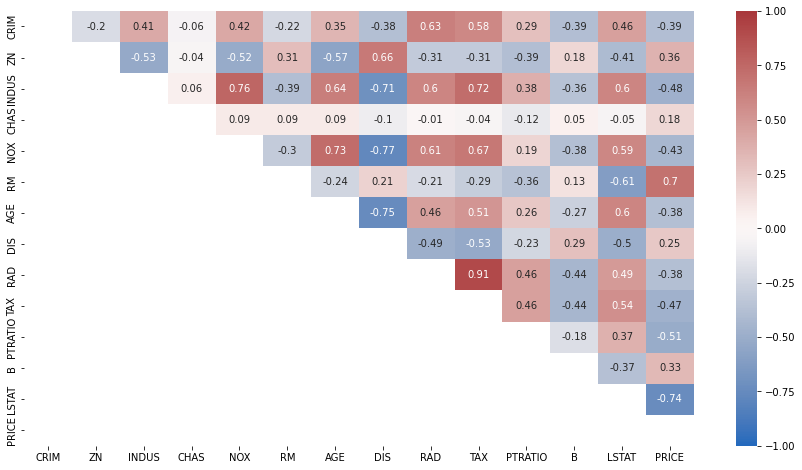

In [5]:
# matriz de correlaciones
df_corr = df_housing.corr().round(2)
mask = np.tril(np.ones_like(df_corr, dtype=bool)) # mascara para mantener el triangulo superior
plt.figure(figsize = (15,8))
sn.heatmap(df_corr, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag',mask=mask)
plt.show()

En las gráficas se muestran los histogramas de cada atributo y también las correlaciones de cada uno de ellos. Se decidió descartar las variables que no muestran una relación marcada, o que la mayoría de los valores están concentrados en uno. Por ejemplo, CHAS, el 93% de los valores es igual a 0. 

También se seleccionaron a prueba y error, las variables que se mantuvieron son: RM, AGE, DIS, LSTAT, PRICE.

In [6]:
variables = ['RM','AGE','DIS','LSTAT','PRICE']

In [31]:
df_housing_var = df_housing[variables]
df_housing_var

,RM,AGE,DIS,LSTAT,PRICE
0,6.575,65.2,4.0900,4.98,24.0
1,6.421,78.9,4.9671,9.14,21.6
2,7.185,61.1,4.9671,4.03,34.7
3,6.998,45.8,6.0622,2.94,33.4
4,7.147,54.2,6.0622,5.33,36.2
...,...,...,...,...,...
501,6.593,69.1,2.4786,9.67,22.4
502,6.120,76.7,2.2875,9.08,20.6
503,6.976,91.0,2.1675,5.64,23.9
504,6.794,89.3,2.3889,6.48,22.0


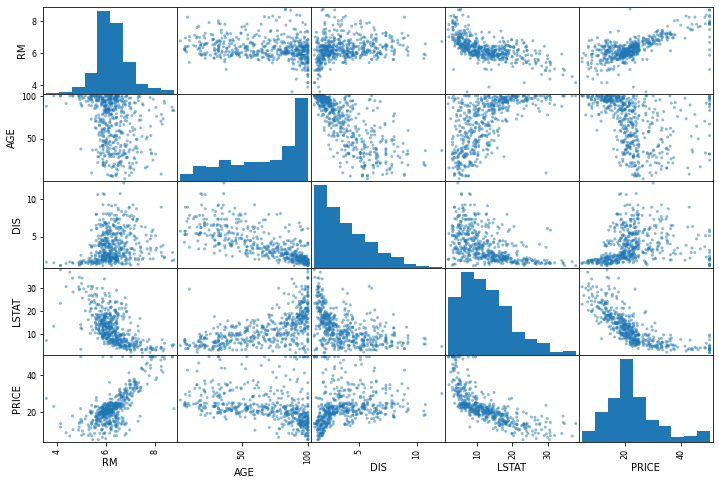

In [9]:
scatter_matrix(df_housing_var, figsize=(12, 8));

## Filtrado y escalado de los datos

En la gráfica de histogramas se pueden observar algunos _outliers_ que serán filtrados:
- Se eliminaron los precios con un valor de 50, ya que probablemente contenían valores alterados o inexactos.
- Se eliminaron los últimos valores de DIS.
- Se eliminaron los últimos valores de LSTAT.
- Se eliminó la tupla donde RM=8.78, ya que es considerado un valor extremo del rango.

In [11]:
# filtrado de los datos
df_housing_var = df_housing_var[df_housing_var['PRICE']!=50]
df_housing_var = df_housing_var[df_housing_var['DIS']<10]
df_housing_var = df_housing_var[df_housing_var['LSTAT']<33]
df_housing_var = df_housing_var[df_housing_var['RM']!=8.78]

In [15]:
# escalar
df_housing_scaled = scaleData(df_housing_var)
df_housing_scaled

,RM,AGE,DIS,LSTAT,PRICE
0,0.623114,0.641607,0.361961,0.099967,0.433790
1,0.591276,0.782698,0.470987,0.238587,0.378995
2,0.749225,0.599382,0.470987,0.068311,0.678082
3,0.710564,0.441813,0.607113,0.031989,0.648402
4,0.741369,0.528321,0.607113,0.111629,0.712329
...,...,...,...,...,...
501,0.626835,0.681771,0.161657,0.256248,0.397260
502,0.529047,0.760041,0.137903,0.236588,0.356164
503,0.706016,0.907312,0.122986,0.121959,0.431507
504,0.668389,0.889804,0.150507,0.149950,0.388128


In [16]:
# guardar en un csv para poder calcular el numero de terminos
df_housing_scaled.to_csv('data/housing_boston_scaled.csv')
# guardar en un numpy array para procesar en numpy
data_housing = df_housing_scaled.to_numpy()
data_housing

array([[0.6231135 , 0.64160659, 0.36196052, 0.09996668, 0.43378995],
       [0.59127558, 0.78269825, 0.47098747, 0.23858714, 0.37899543],
       [0.74922473, 0.59938208, 0.47098747, 0.06831056, 0.67808219],
       ...,
       [0.70601613, 0.90731205, 0.12298628, 0.12195935, 0.43150685],
       [0.6683895 , 0.88980433, 0.15050716, 0.14995002, 0.38812785],
       [0.51044036, 0.80226571, 0.16493884, 0.19660113, 0.15753425]])

## Calcular el número de términos

In [17]:
n_terms = EGA.findNumberTerms('data/housing_boston_scaled.csv',delimiter=',')
n_terms

9

El número de términos del polinomio aproximante según la NN, es de $9\pm  2$

## Ejecución del algoritmo en $\pm2$ términos

In [18]:
# parametros de EGA
n_individuals = 150 # tamanio de la poblacion
cross_probability = 0.9 # prob de cruza
mutation_probability = 0.05 # prob de mutacion
max_generations = 200 # numero max de generaciones

running...
Generation: 0, Min fitness: 0.10742420950356889
Generation: 10, Min fitness: 0.08298194478703053
Generation: 20, Min fitness: 0.07778322796800936
Generation: 30, Min fitness: 0.07778322796800936
Generation: 40, Min fitness: 0.07778322796800936
Generation: 50, Min fitness: 0.07778322796800936
Generation: 60, Min fitness: 0.07778322796800936
Generation: 70, Min fitness: 0.07778322796800936
Generation: 80, Min fitness: 0.07676491255792635
Generation: 90, Min fitness: 0.07676491255792635
Generation: 100, Min fitness: 0.07676491255792635
Generation: 110, Min fitness: 0.07676491255792635
Generation: 120, Min fitness: 0.07676491255792635
Generation: 130, Min fitness: 0.07557885593573077
Generation: 140, Min fitness: 0.07557885593573077
Generation: 150, Min fitness: 0.07557885593573077
Generation: 160, Min fitness: 0.07557885593573077
Generation: 170, Min fitness: 0.07557885593573077
Generation: 180, Min fitness: 0.07557885593573077
Generation: 190, Min fitness: 0.07557885593573077


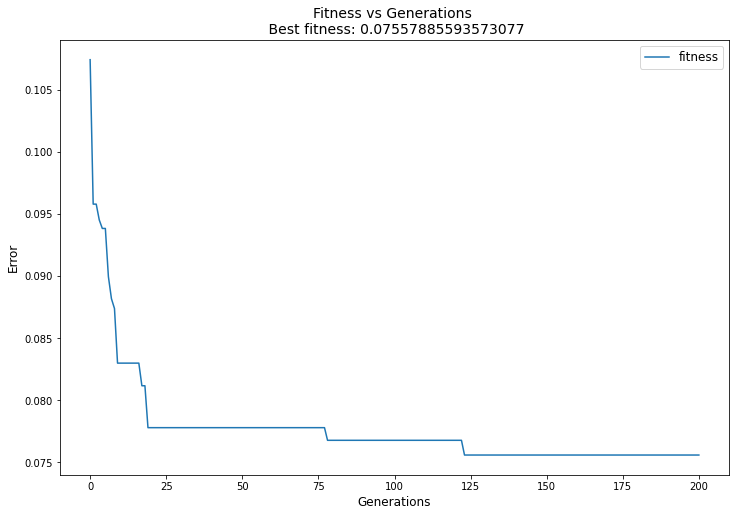

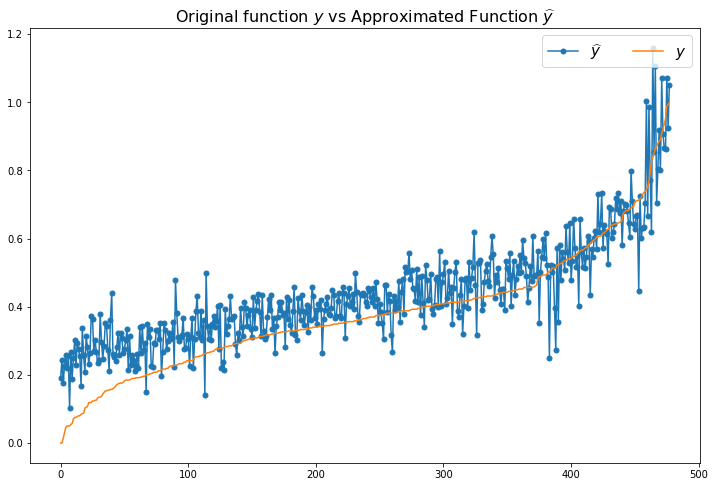


*** RESULTS ***
E_MMX_TRAIN: 0.2570408009 	 E_RMS_TRAIN: 0.0936855806
E_MMX_TEST:  0.3225574081 	 E_RMS_TEST:  0.1070810867
E_MMX:       0.3225582834 	 E_RMS:       0.0965251622

C[0, 0, 0, 0] = 0.3953857422
C[1, 3, 0, 1] = -0.3155571734
C[2, 0, 0, 1] = -0.9261395601
C[2, 9, 4, 0] = -1.3841334324
C[3, 0, 0, 0] = 0.8252278778
C[8, 1, 0, 0] = -0.0179406552

Equation:


<IPython.core.display.Latex object>

*** SUGGESTED TERMS ***

Mean attributions per term:

t1: Mean relative term attribution: 102.25%	 Mean term attribution: 0.3953857421875
t2: Mean relative term attribution: -11.78%	 Mean term attribution: -0.034223377804538296
t3: Mean relative term attribution: -26.96%	 Mean term attribution: -0.09097150133099118
t4: Mean relative term attribution: -0.28%	 Mean term attribution: -0.0007755872935112229
t5: Mean relative term attribution: 36.83%	 Mean term attribution: 0.16666460155668406
t6: Mean relative term attribution: -0.06%	 Mean term attribution: -0.0003884185330852748


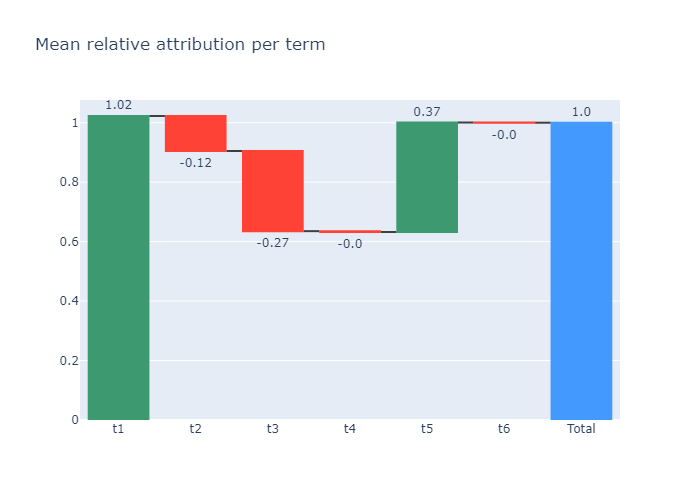

Suggested terms: ['term1', 'term2', 'term3', 'term5']


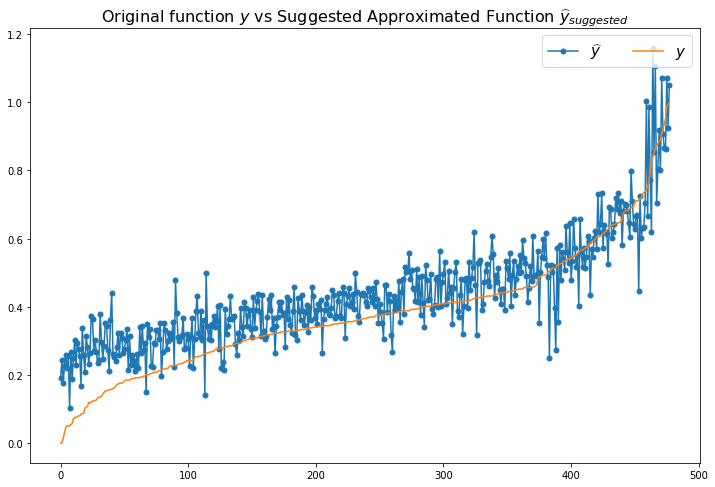


*** RESULTS - SUGGESTED ***
E_RMS: 	0.0969432043 
E_MMX: 	0.3352031977 

C[0, 0, 0, 0] = 0.3953857422
C[3, 0, 0, 0] = 0.8252278778
C[2, 0, 0, 1] = -0.9261395601
C[1, 3, 0, 1] = -0.3155571734

Suggested Equation:


<IPython.core.display.Latex object>

In [21]:
_,_,_ = EGA.EGA_CV(data_housing,n_individuals,cross_probability,mutation_probability,
           max_generations,n_terms=7,error='rms',max_degree=9,max_monomial_degree=81,
           distribution='normal',train_pp=0.8,randomly_split=True,
            stabilize_data=True,stabilize_factor=1/1e12,
           quasi_factor=0.0,max_iterations = 10000,
           plot_res_fitness=True,plot_best_results=True,plot_sort=True,
           plot_errors=False,save_plots=False, save_name_plots='',
            save_results=True,save_name='results_EGA_7.txt',print_gens=True,
            suggested_polynomial=True, suggested_threshold=0.98)

running...
Generation: 0, Min fitness: 0.09366612177072331
Generation: 10, Min fitness: 0.08132575583660825
Generation: 20, Min fitness: 0.07916199823209263
Generation: 30, Min fitness: 0.07798018466477237
Generation: 40, Min fitness: 0.07767573311569374
Generation: 50, Min fitness: 0.07767573311569374
Generation: 60, Min fitness: 0.07754039004199825
Generation: 70, Min fitness: 0.07754039004199825
Generation: 80, Min fitness: 0.07754039004199825
Generation: 90, Min fitness: 0.07754039004199825
Generation: 100, Min fitness: 0.07754039004199825
Generation: 110, Min fitness: 0.07754039004199825
Generation: 120, Min fitness: 0.07754039004199825
Generation: 130, Min fitness: 0.07754039004199825
Generation: 140, Min fitness: 0.07754039004199825
Generation: 150, Min fitness: 0.07754039004199825
Generation: 160, Min fitness: 0.07754039004199825
Generation: 170, Min fitness: 0.07747147521509239
Generation: 180, Min fitness: 0.07747147521509239
Generation: 190, Min fitness: 0.07747147521509239


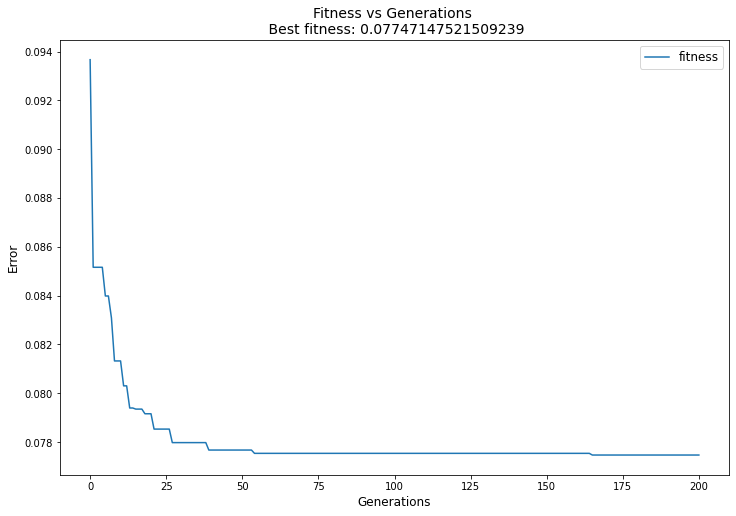

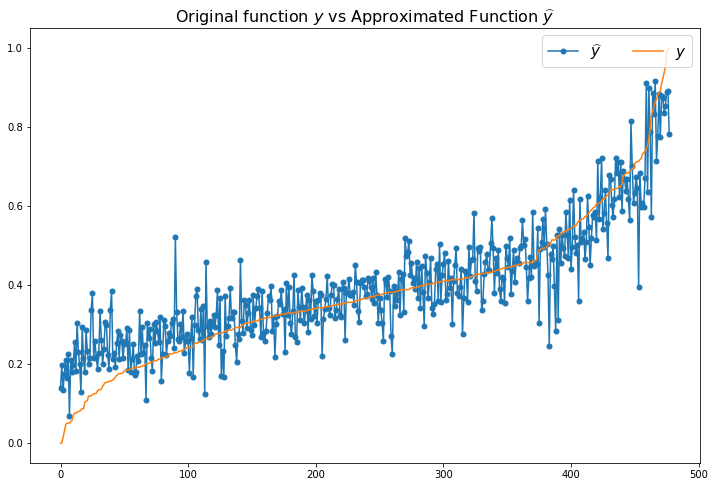


*** RESULTS ***
E_MMX_TRAIN: 0.2214577386 	 E_RMS_TRAIN: 0.0793354555
E_MMX_TEST:  0.3166820731 	 E_RMS_TEST:  0.0840659062
E_MMX:       0.3166796549 	 E_RMS:       0.0803083254

C[0, 0, 0, 0] = 0.3962660904
C[1, 1, 0, 1] = -0.6979526223
C[3, 0, 0, 0] = -0.1456298828
C[5, 0, 0, 0] = 1.9087365622
C[6, 1, 0, 4] = -1.8307998278
C[9, 0, 0, 0] = -1.2940368652

Equation:


<IPython.core.display.Latex object>

*** SUGGESTED TERMS ***

Mean attributions per term:

t1: Mean relative term attribution: 115.86%	 Mean term attribution: 0.39626609043449257
t2: Mean relative term attribution: -37.32%	 Mean term attribution: -0.09917477745538911
t3: Mean relative term attribution: -7.18%	 Mean term attribution: -0.029411689844747253
t4: Mean relative term attribution: 35.47%	 Mean term attribution: 0.16842790823403206
t5: Mean relative term attribution: -1.04%	 Mean term attribution: -0.0021012180399603477
t6: Mean relative term attribution: -5.78%	 Mean term attribution: -0.0371142524081989


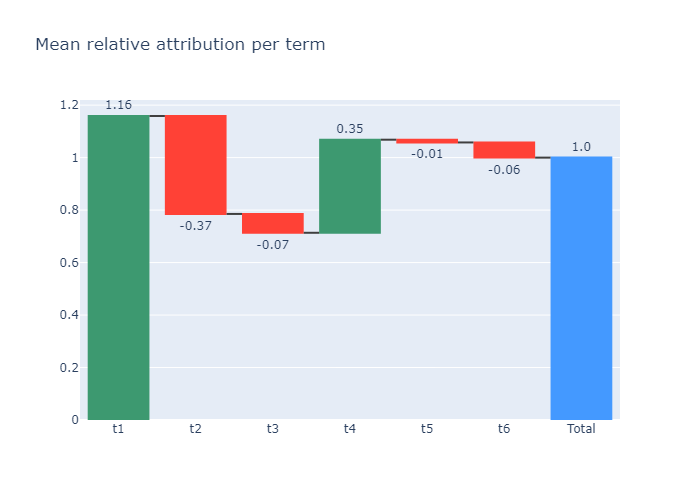

Suggested terms: ['term1', 'term2', 'term3', 'term4', 'term6']


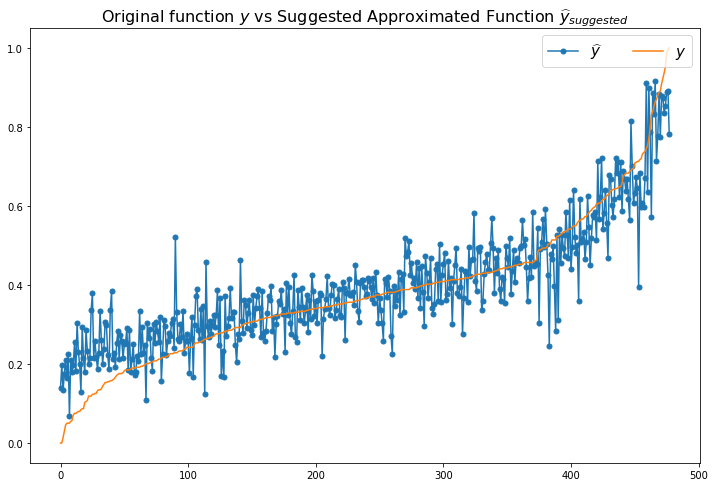


*** RESULTS - SUGGESTED ***
E_RMS: 	0.0815757154 
E_MMX: 	0.3165801179 

C[0, 0, 0, 0] = 0.3962660904
C[1, 1, 0, 1] = -0.6979526223
C[5, 0, 0, 0] = 1.9087365622
C[3, 0, 0, 0] = -0.1456298828
C[9, 0, 0, 0] = -1.2940368652

Suggested Equation:


<IPython.core.display.Latex object>

In [22]:
_,_,_ = EGA.EGA_CV(data_housing,n_individuals,cross_probability,mutation_probability,
           max_generations,n_terms=8,error='rms',max_degree=9,max_monomial_degree=81,
           distribution='normal',train_pp=0.8,randomly_split=True,
            stabilize_data=True,stabilize_factor=1/1e12,
           quasi_factor=0.0,max_iterations = 10000,
           plot_res_fitness=True,plot_best_results=True,plot_sort=True,
           plot_errors=False,save_plots=False, save_name_plots='',
            save_results=True,save_name='results_EGA_8.txt',print_gens=True,
            suggested_polynomial=True, suggested_threshold=0.98)

running...
Generation: 0, Min fitness: 0.09780998127859176
Generation: 10, Min fitness: 0.08934954408433718
Generation: 20, Min fitness: 0.0854548701612208
Generation: 30, Min fitness: 0.08329841370678288
Generation: 40, Min fitness: 0.08236839778916685
Generation: 50, Min fitness: 0.08236839778916685
Generation: 60, Min fitness: 0.08236839778916685
Generation: 70, Min fitness: 0.08186403732477099
Generation: 80, Min fitness: 0.08132574638373709
Generation: 90, Min fitness: 0.07986465552768572
Generation: 100, Min fitness: 0.07986465552768572
Generation: 110, Min fitness: 0.07986465552768572
Generation: 120, Min fitness: 0.07986465552768572
Generation: 130, Min fitness: 0.07986465552768572
Generation: 140, Min fitness: 0.07986465552768572
Generation: 150, Min fitness: 0.07986465552768572
Generation: 160, Min fitness: 0.0798244028662642
Generation: 170, Min fitness: 0.0798244028662642
Generation: 180, Min fitness: 0.07972231748060969
Generation: 190, Min fitness: 0.07972231748060969
Gen

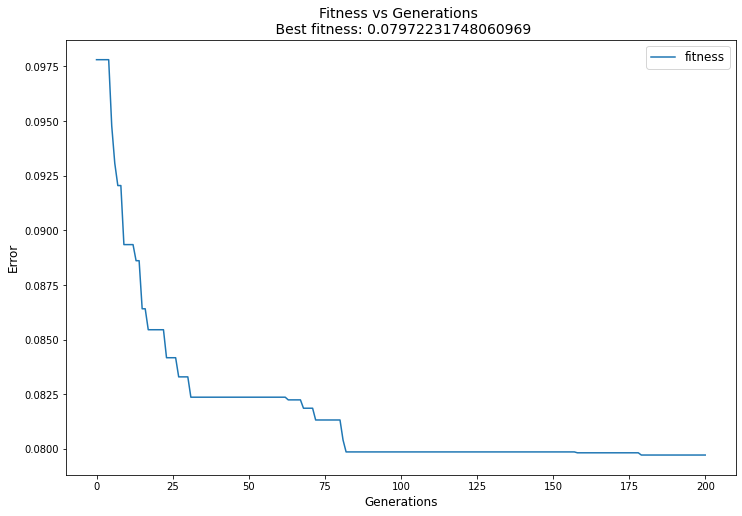

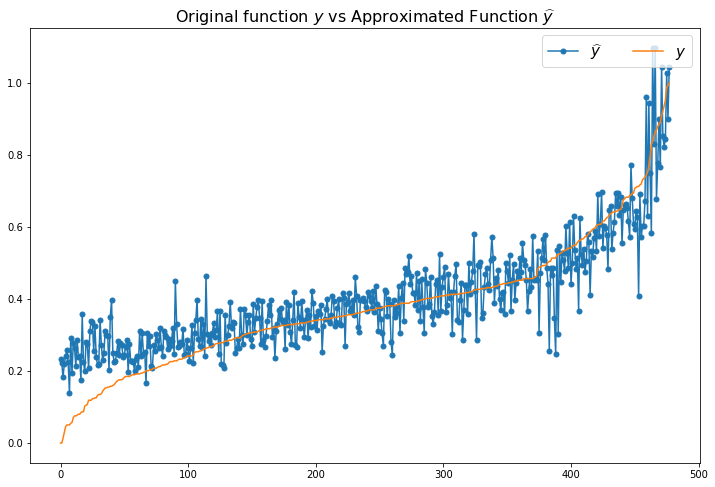


*** RESULTS ***
E_MMX_TRAIN: 0.2465275469 	 E_RMS_TRAIN: 0.0867506926
E_MMX_TEST:  0.2398046206 	 E_RMS_TEST:  0.0784690655
E_MMX:       0.3044207904 	 E_RMS:       0.0851522831

C[0, 0, 0, 0] = 0.3457641602
C[0, 4, 0, 3] = 0.1377383350
C[1, 3, 0, 1] = -0.4521589222
C[1, 3, 1, 2] = 0.1554237700
C[2, 0, 0, 1] = -0.7961433534
C[3, 0, 0, 0] = 0.8670293989
C[7, 2, 2, 0] = -1.3078091324

Equation:


<IPython.core.display.Latex object>

*** SUGGESTED TERMS ***

Mean attributions per term:

t1: Mean relative term attribution: 96.54%	 Mean term attribution: 0.34576416015625
t2: Mean relative term attribution: 4.31%	 Mean term attribution: 0.010681808835975106
t3: Mean relative term attribution: -17.84%	 Mean term attribution: -0.04903835793776047
t4: Mean relative term attribution: 0.50%	 Mean term attribution: 0.0013782249029080295
t5: Mean relative term attribution: -24.78%	 Mean term attribution: -0.0782024213715365
t6: Mean relative term attribution: 41.65%	 Mean term attribution: 0.17510691676436377
t7: Mean relative term attribution: -0.39%	 Mean term attribution: -0.002218080299456688


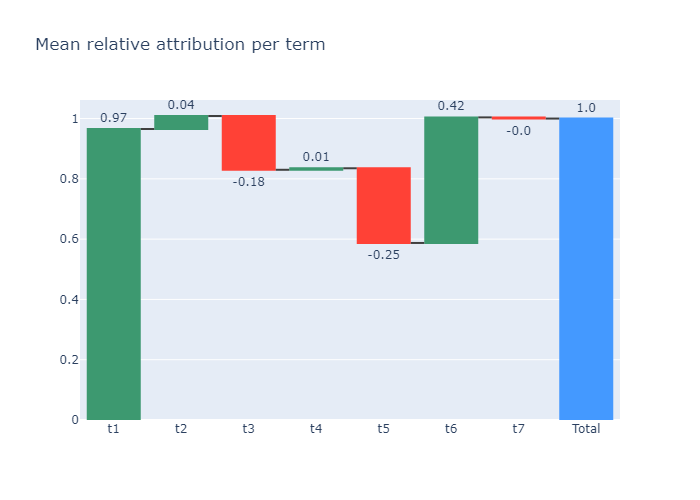

Suggested terms: ['term1', 'term2', 'term3', 'term5', 'term6']


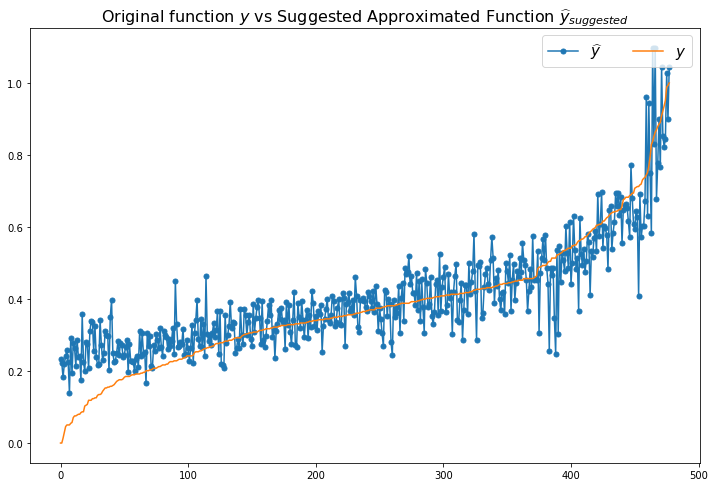


*** RESULTS - SUGGESTED ***
E_RMS: 	0.0860538463 
E_MMX: 	0.3270517023 

C[0, 0, 0, 0] = 0.3457641602
C[3, 0, 0, 0] = 0.8670293989
C[2, 0, 0, 1] = -0.7961433534
C[1, 3, 0, 1] = -0.4521589222
C[0, 4, 0, 3] = 0.1377383350

Suggested Equation:


<IPython.core.display.Latex object>

In [20]:
_,_,_ = EGA.EGA_CV(data_housing,n_individuals,cross_probability,mutation_probability,
           max_generations,n_terms,error='rms',max_degree=9,max_monomial_degree=81,
           distribution='normal',train_pp=0.8,randomly_split=True,
            stabilize_data=True,stabilize_factor=1/1e12,
           quasi_factor=0.0,max_iterations = 10000,
           plot_res_fitness=True,plot_best_results=True,plot_sort=True,
           plot_errors=False,save_plots=False, save_name_plots='',
            save_results=True,save_name='results_EGA_9.txt',print_gens=True,
            suggested_polynomial=True, suggested_threshold=0.98)

running...
Generation: 0, Min fitness: 0.0890996291644218
Generation: 10, Min fitness: 0.08039840755994423
Generation: 20, Min fitness: 0.07813799340405354
Generation: 30, Min fitness: 0.07687233043365786
Generation: 40, Min fitness: 0.07652620318017914
Generation: 50, Min fitness: 0.07652620318017914
Generation: 60, Min fitness: 0.07652620318017914
Generation: 70, Min fitness: 0.07630731101597438
Generation: 80, Min fitness: 0.07630731101587442
Generation: 90, Min fitness: 0.07630731101586255
Generation: 100, Min fitness: 0.0763073110158577
Generation: 110, Min fitness: 0.0763073110158577
Generation: 120, Min fitness: 0.0763073110158577
Generation: 130, Min fitness: 0.0763073110158577
Generation: 140, Min fitness: 0.0763073110158577
Generation: 150, Min fitness: 0.0763073110158577
Generation: 160, Min fitness: 0.0763073110158577
Generation: 170, Min fitness: 0.0763073110158577
Generation: 180, Min fitness: 0.0763073110158577
Generation: 190, Min fitness: 0.07629555893709522
Generation

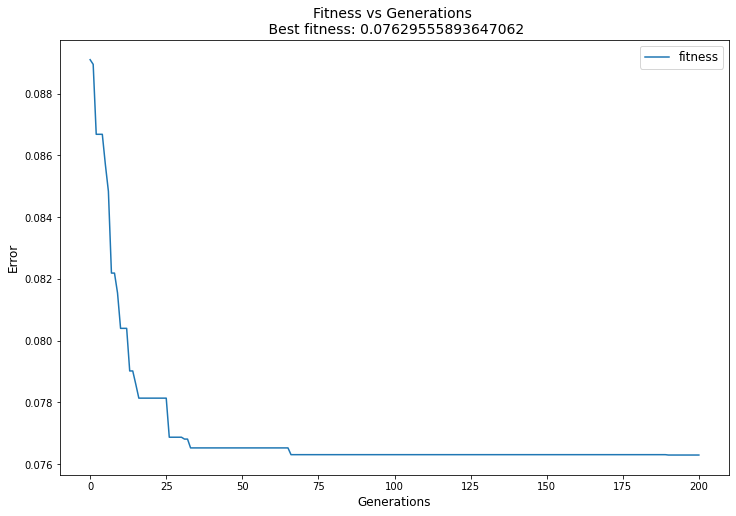

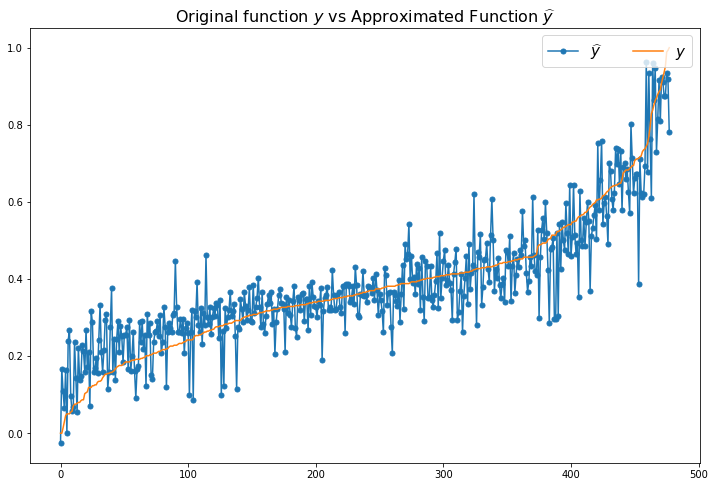


*** RESULTS ***
E_MMX_TRAIN: 0.2181619790 	 E_RMS_TRAIN: 0.0762955589
E_MMX_TEST:  0.3264349159 	 E_RMS_TEST:  0.0801162818
E_MMX:       0.3264349159 	 E_RMS:       0.0770781010

C[0, 0, 0, 0] = 0.2955366511
C[2, 3, 0, 2] = -1.0360328606
C[2, 5, 0, 4] = -3.6976937528
C[3, 0, 0, 0] = 0.1963294524
C[3, 1, 2, 5] = 14.0004072094
C[4, 0, 0, 1] = -0.4436784491
C[4, 7, 0, 4] = 16.2683872816
C[5, 0, 0, 0] = 2.6979148078
C[5, 0, 0, 2] = -5.8300643495
C[7, 0, 0, 0] = -2.2382005097

Equation:


<IPython.core.display.Latex object>

*** SUGGESTED TERMS ***

Mean attributions per term:

t1: Mean relative term attribution: -8269.99%	 Mean term attribution: 0.2955366510939777
t2: Mean relative term attribution: 3194.50%	 Mean term attribution: -0.03133566841930258
t3: Mean relative term attribution: 10139.91%	 Mean term attribution: -0.040591781607182804
t4: Mean relative term attribution: -237.88%	 Mean term attribution: 0.03965107195345342
t5: Mean relative term attribution: -12.36%	 Mean term attribution: 0.0026901780004030215
t6: Mean relative term attribution: 186.19%	 Mean term attribution: -0.014224552826686982
t7: Mean relative term attribution: -5386.29%	 Mean term attribution: 0.043277405816207634
t8: Mean relative term attribution: -376.53%	 Mean term attribution: 0.23806540759323927
t9: Mean relative term attribution: 837.04%	 Mean term attribution: -0.04303217589581449
t10: Mean relative term attribution: 25.42%	 Mean term attribution: -0.10370685930768393


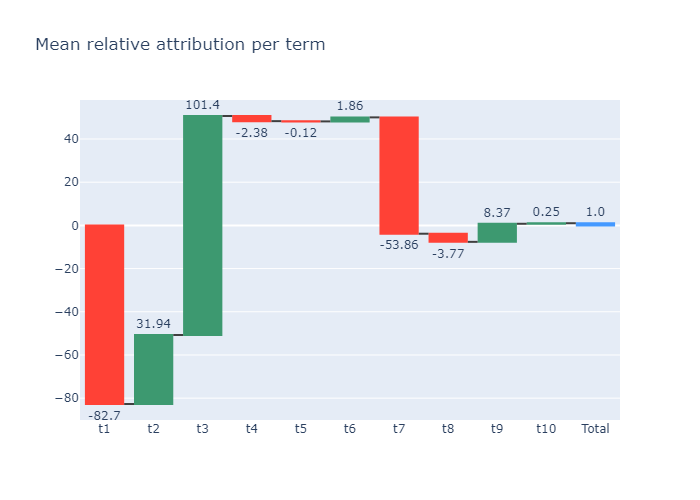

Suggested terms: ['term1', 'term2', 'term3', 'term7', 'term8', 'term9']


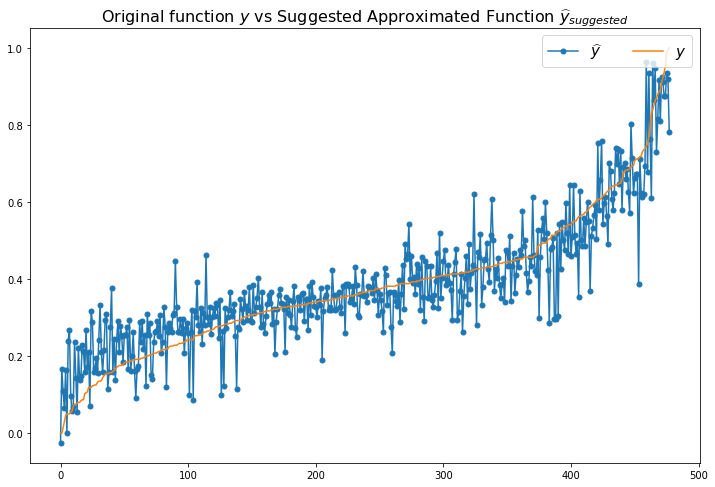


*** RESULTS - SUGGESTED ***
E_RMS: 	0.2538288309 
E_MMX: 	1.9881089534 

C[2, 5, 0, 4] = -3.6976937528
C[0, 0, 0, 0] = 0.2955366511
C[4, 7, 0, 4] = 16.2683872816
C[2, 3, 0, 2] = -1.0360328606
C[5, 0, 0, 2] = -5.8300643495
C[5, 0, 0, 0] = 2.6979148078

Suggested Equation:


<IPython.core.display.Latex object>

In [23]:
_,_,_ = EGA.EGA_CV(data_housing,n_individuals,cross_probability,mutation_probability,
           max_generations,n_terms=10,error='rms',max_degree=9,max_monomial_degree=81,
           distribution='normal',train_pp=0.8,randomly_split=True,
            stabilize_data=True,stabilize_factor=1/1e12,
           quasi_factor=0.0,max_iterations = 10000,
           plot_res_fitness=True,plot_best_results=True,plot_sort=True,
           plot_errors=False,save_plots=False, save_name_plots='',
            save_results=True,save_name='results_EGA_10.txt',print_gens=True,
            suggested_polynomial=True, suggested_threshold=0.98)

running...
Generation: 0, Min fitness: 0.0977731461956112
Generation: 10, Min fitness: 0.08371096531263678
Generation: 20, Min fitness: 0.08043377196272532
Generation: 30, Min fitness: 0.08043377196272532
Generation: 40, Min fitness: 0.08043377196272532
Generation: 50, Min fitness: 0.07996192283281874
Generation: 60, Min fitness: 0.07923223932537399
Generation: 70, Min fitness: 0.0790287790760545
Generation: 80, Min fitness: 0.0790287790760545
Generation: 90, Min fitness: 0.07896462666603073
Generation: 100, Min fitness: 0.07895369443939419
Generation: 110, Min fitness: 0.07885972324097196
Generation: 120, Min fitness: 0.07866823732603842
Generation: 130, Min fitness: 0.07856702111744356
Generation: 140, Min fitness: 0.07781167142757177
Generation: 150, Min fitness: 0.07781167142757177
Generation: 160, Min fitness: 0.07781167142757177
Generation: 170, Min fitness: 0.07781167142757177
Generation: 180, Min fitness: 0.07781167142757177
Generation: 190, Min fitness: 0.07781167142757177
Gen

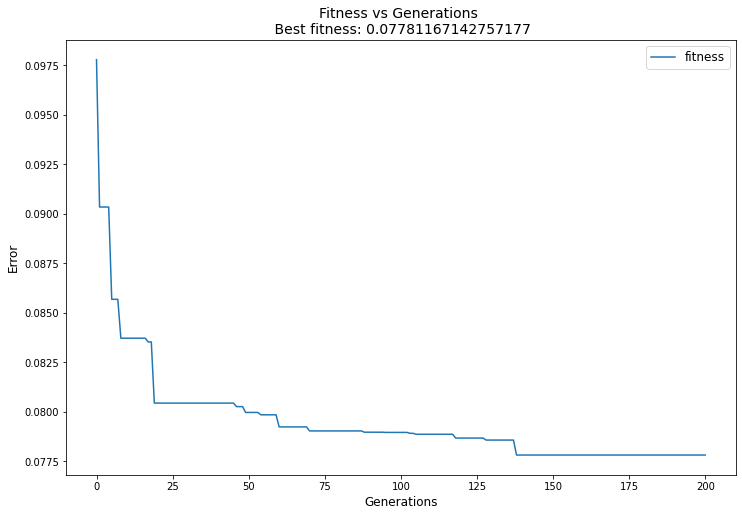

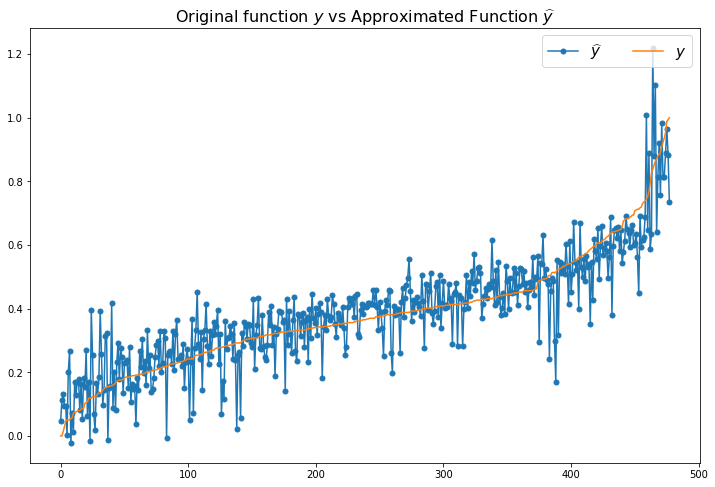


*** RESULTS ***
E_MMX_TRAIN: 0.2566546936 	 E_RMS_TRAIN: 0.0879536699
E_MMX_TEST:  0.3820059429 	 E_RMS_TEST:  0.0890246074
E_MMX:       0.3820070752 	 E_RMS:       0.0881699664

C[0, 0, 0, 0] = 0.2959136963
C[0, 5, 1, 1] = 0.7743484467
C[1, 1, 1, 0] = -0.6577228961
C[1, 2, 0, 2] = -2.7708220247
C[2, 0, 0, 1] = 1.1469062409
C[2, 5, 0, 4] = 3.9796735035
C[3, 0, 0, 0] = 1.1650176357
C[6, 0, 0, 1] = -6.4453597949
C[8, 3, 0, 0] = 0.1074973284

Equation:


<IPython.core.display.Latex object>

*** SUGGESTED TERMS ***

Mean attributions per term:

t1: Mean relative term attribution: 111.81%	 Mean term attribution: 0.2959136962890625
t2: Mean relative term attribution: 10.76%	 Mean term attribution: 0.020889093752037007
t3: Mean relative term attribution: -18.13%	 Mean term attribution: -0.061916218457848254
t4: Mean relative term attribution: -152.31%	 Mean term attribution: -0.18042445703426985
t5: Mean relative term attribution: 53.87%	 Mean term attribution: 0.11265665252553216
t6: Mean relative term attribution: 55.10%	 Mean term attribution: 0.043687240891317036
t7: Mean relative term attribution: 67.06%	 Mean term attribution: 0.23528919136036874
t8: Mean relative term attribution: -28.51%	 Mean term attribution: -0.07898787043663762
t9: Mean relative term attribution: 0.35%	 Mean term attribution: 0.001377115197192753


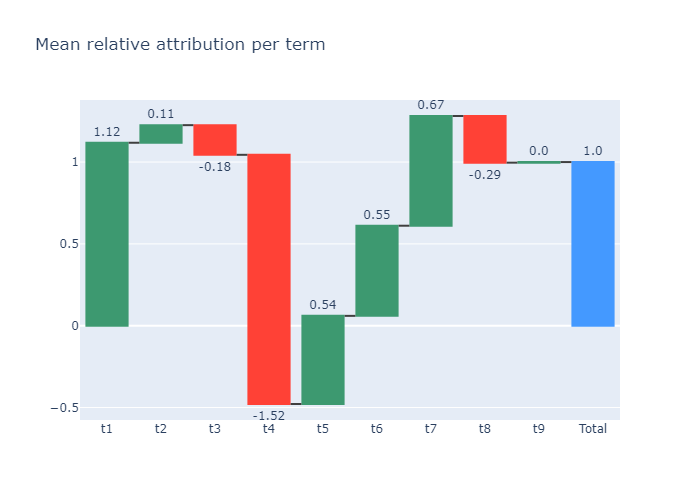

Suggested terms: ['term1', 'term2', 'term3', 'term4', 'term5', 'term6', 'term7', 'term8']


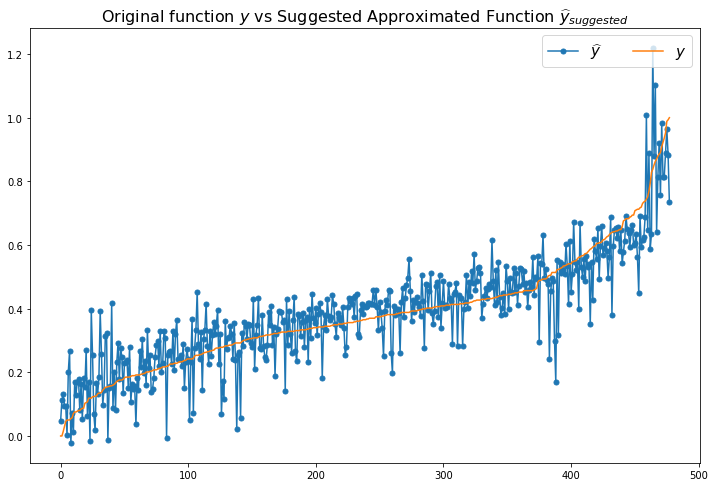


*** RESULTS - SUGGESTED ***
E_RMS: 	0.0885505751 
E_MMX: 	0.3499781125 

C[1, 2, 0, 2] = -2.7708220247
C[0, 0, 0, 0] = 0.2959136963
C[3, 0, 0, 0] = 1.1650176357
C[2, 5, 0, 4] = 3.9796735035
C[2, 0, 0, 1] = 1.1469062409
C[6, 0, 0, 1] = -6.4453597949
C[1, 1, 1, 0] = -0.6577228961
C[0, 5, 1, 1] = 0.7743484467

Suggested Equation:


<IPython.core.display.Latex object>

In [24]:
_,_,_ = EGA.EGA_CV(data_housing,n_individuals,cross_probability,mutation_probability,
           max_generations,n_terms=11,error='rms',max_degree=9,max_monomial_degree=81,
           distribution='normal',train_pp=0.8,randomly_split=True,
            stabilize_data=True,stabilize_factor=1/1e12,
           quasi_factor=0.0,max_iterations = 10000,
           plot_res_fitness=True,plot_best_results=True,plot_sort=True,
           plot_errors=False,save_plots=False, save_name_plots='',
            save_results=True,save_name='results_EGA_11.txt',print_gens=True,
            suggested_polynomial=True, suggested_threshold=0.98)

El valor del error RMS del conjunto de prueba para cada número de términos es el siguiente:
- RMS(T-2) = 0.107081
- RMS(T-1) = 0.084066
- __RMS(T) = 0.078469__
- RMS(T+1) = 0.080116
- RMS(T+2) = 0.089024

Se observa que el número de términos que arroja mejores resultados es cuando $T=9$, y la ecuación que lo describe es:

\begin{equation}
f(X)=+0.346+0.867x_{1}^{3}-0.796x_{1}^{2}x_{4}-0.452x_{1}x_{2}^{3}x_{4}+0.138x_{2}^{4}x_{4}^{3}
\end{equation}